In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import entropy
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import os

sys.path.append(os.path.abspath(".."))


SEED = 16

data=np.load("../datasets/labeled/first_batch_multi_labels.npz")
data2=np.load("../datasets/labeled/second_batch_multi_labels.npz")
data3=np.load("../datasets/labeled/third_batch_multi_labels.npz")

X1=data["X"]
y1=data["y"]

X2=data2["X"]
y2=data2["y"]

X3=data3["X"]
y3=data3["y"]

X=np.concatenate((X1,X2,X3),axis=0)
y=np.concatenate((y1,y2,y3),axis=0)

XX=pd.DataFrame(X)
yy=pd.DataFrame(y)
XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
yy.rename(columns={0:"user",1:"label"},inplace=True)

In [2]:
# Merge labels into main dataset
XX = XX.merge(yy, on="user", how="left").sort_values(by=["user", "item"]).reset_index(drop=True)

print(XX.shape)
XX.head()

(524883, 4)


,user,item,rating,label
0,0,9,0,0
1,0,12,10,0
2,0,13,10,0
3,0,15,10,0
4,0,16,1,0


In [3]:
from utils.feature_transformation import aggregate_features

user_features = aggregate_features(XX)
user_features = user_features.merge(yy, on="user", how="left")
print(user_features.shape)
# user_features.to_csv("user_features.csv", index=False)
user_features.head()

(3300, 87)


,user,review_count,avg_rating,std_rating,like_count,dislike_count,unknown_count,neutral_count,like_pct,dislike_pct,...,item_mean_vs_user_avg,item_skew_bias,normalized_movie_popularity,popularity_skew,rating_polarity,activity_weighted_skew,switch_pct,dominant_rating,dominance_ratio,label
0,0,168,5.946429,5.253181,100,5,49,14,0.595238,0.029762,...,-3.066024,-0.437554,1.0,2282,0.565476,-2.817185,0.714286,10,0.595238,0
1,1,208,3.158654,5.890205,76,16,57,59,0.365385,0.076923,...,-0.082865,-0.454684,1.0,2333,0.288462,-1.703270,0.740385,10,0.365385,0
2,2,195,1.025641,7.750913,66,52,60,17,0.338462,0.266667,...,1.954071,-0.449163,1.0,2294,0.071795,-1.356825,0.805128,10,0.338462,3
3,3,41,1.073171,6.455193,10,7,14,10,0.243902,0.170732,...,2.567873,-0.533277,1.0,1990,0.073171,-0.522866,0.634146,1,0.341463,0
4,4,6,6.833333,4.915960,4,0,1,1,0.666667,0.000000,...,-3.739258,-0.500907,1.0,1578,0.666667,-1.449192,0.833333,10,0.666667,0


In [4]:
from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

df = user_features.copy()

# TODO: To achieve the best result, need to select the best features based on SHAP. Just uncomment this code to get the highest AUC so far.
# # SHAP-guided feature filtering
# keep = set([
#     "user", "label",
#     'unknown_pct', 'min_movie', 'z_rating_median',
#        'popularity_vs_deviation', 'gap_mean', 'mean_rating_diff',
#        'std_movie_popularity', 'std_deviation', 'max_movie', 'average_product',
#        'max_abs_rating_diff', 'std_rating', 'likes_rare', 'variance_movie',
#        'avg_rating', 'min_movie_popularity', 'like_dislike_ratio', 'gap_max',
#        'rare_movies_watched_pct', 'rare_like_ratio', 'median_movie',
#        'dislike_pct', 'mean_abs_deviation', 'max_movie_popularity',
#        'user_pop_percentile_std', 'rating_entropy', 'z_rating_max',
#        'max_abs_deviation', 'sum_item_rating'
# ])
# df = df[[col for col in df.columns if col in keep]]

print(df.shape)
df.head()

(3300, 87)


,user,review_count,avg_rating,std_rating,like_count,dislike_count,unknown_count,neutral_count,like_pct,dislike_pct,...,item_mean_vs_user_avg,item_skew_bias,normalized_movie_popularity,popularity_skew,rating_polarity,activity_weighted_skew,switch_pct,dominant_rating,dominance_ratio,label
0,0,168,5.946429,5.253181,100,5,49,14,0.595238,0.029762,...,-3.066024,-0.437554,1.0,2282,0.565476,-2.817185,0.714286,10,0.595238,0
1,1,208,3.158654,5.890205,76,16,57,59,0.365385,0.076923,...,-0.082865,-0.454684,1.0,2333,0.288462,-1.703270,0.740385,10,0.365385,0
2,2,195,1.025641,7.750913,66,52,60,17,0.338462,0.266667,...,1.954071,-0.449163,1.0,2294,0.071795,-1.356825,0.805128,10,0.338462,3
3,3,41,1.073171,6.455193,10,7,14,10,0.243902,0.170732,...,2.567873,-0.533277,1.0,1990,0.073171,-0.522866,0.634146,1,0.341463,0
4,4,6,6.833333,4.915960,4,0,1,1,0.666667,0.000000,...,-3.739258,-0.500907,1.0,1578,0.666667,-1.449192,0.833333,10,0.666667,0


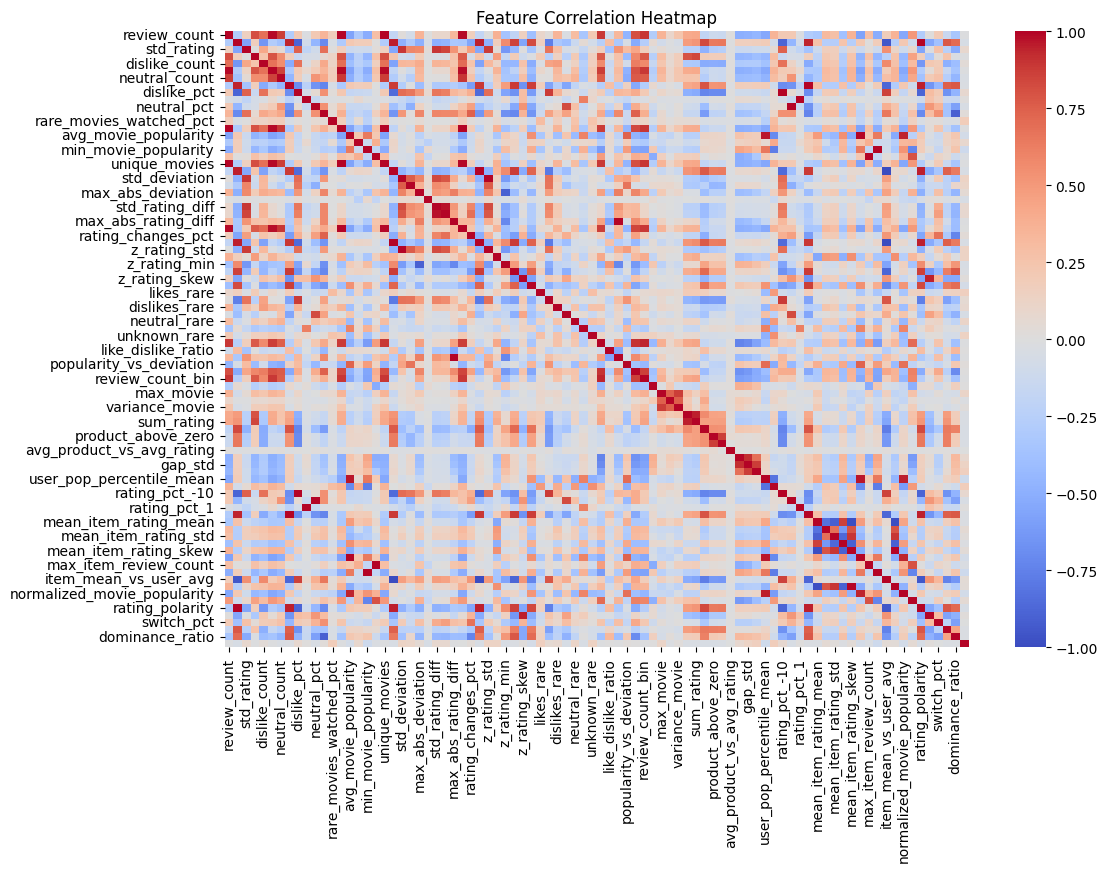

In [5]:
df.drop(columns=["user"], inplace=True)
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
correlated_features = set()
threshold = 0.9

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

df.drop(columns=correlated_features, inplace=True, errors="ignore")
print(f"Dropped correlated features: {correlated_features}")

Dropped correlated features: {'review_count_bin', 'mean_item_review_count', 'user_pop_percentile_mean', 'rating_pct_1', 'z_rating_std', 'sum_rating', 'mean_abs_rating_diff', 'mean_item_rating_skew', 'z_rating_mean', 'min_item_review_count', 'mean_item_rating_std', 'change_direction_count', 'rating_pct_-10', 'like_pct', 'z_rating_min', 'dominance_ratio', 'gap_std', 'activity_weighted_skew', 'rating_pct_0', 'unique_movies', 'item_mean_vs_user_avg', 'rating_pct_10', 'normalized_movie_popularity', 'item_skew_bias', 'rating_polarity', 'rating_range', 'entropy_by_count', 'rating_changes_count', 'max_item_review_count', 'unknown_count', 'mean_deviation'}


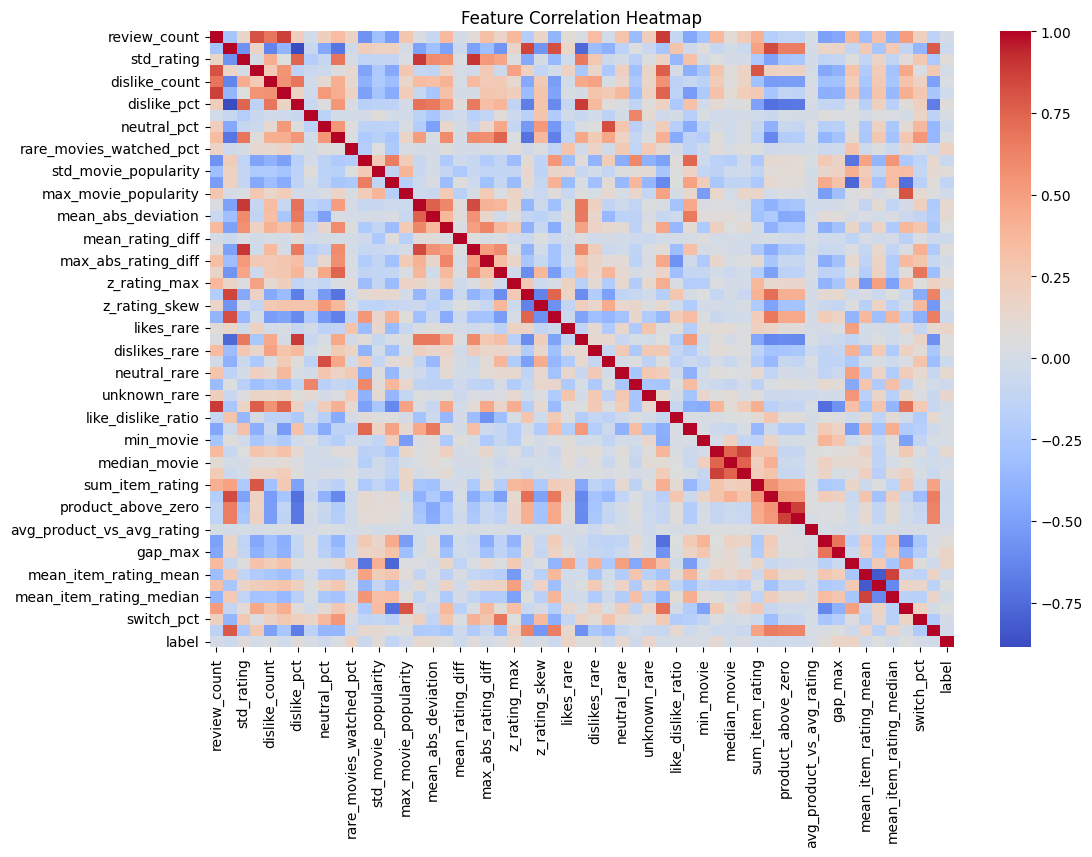

In [7]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
# Define features and target
X = df.drop(columns=["label"])
y = df["label"]

print(X.columns)
X.head()

Index(['review_count', 'avg_rating', 'std_rating', 'like_count',
       'dislike_count', 'neutral_count', 'dislike_pct', 'unknown_pct',
       'neutral_pct', 'rating_entropy', 'rare_movies_watched_pct',
       'avg_movie_popularity', 'std_movie_popularity', 'min_movie_popularity',
       'max_movie_popularity', 'std_deviation', 'mean_abs_deviation',
       'max_abs_deviation', 'mean_rating_diff', 'std_rating_diff',
       'max_abs_rating_diff', 'rating_changes_pct', 'z_rating_max',
       'z_rating_median', 'z_rating_skew', 'likes_popular', 'likes_rare',
       'dislikes_popular', 'dislikes_rare', 'neutral_popular', 'neutral_rare',
       'unknown_popular', 'unknown_rare', 'interaction_entropy',
       'like_dislike_ratio', 'popularity_vs_deviation', 'min_movie',
       'max_movie', 'median_movie', 'variance_movie', 'sum_item_rating',
       'average_product', 'product_above_zero', 'sum_above_zero',
       'avg_product_vs_avg_rating', 'gap_mean', 'gap_max',
       'user_pop_percentile_

,review_count,avg_rating,std_rating,like_count,dislike_count,neutral_count,dislike_pct,unknown_pct,neutral_pct,rating_entropy,...,avg_product_vs_avg_rating,gap_mean,gap_max,user_pop_percentile_std,mean_item_rating_mean,std_item_rating_mean,mean_item_rating_median,popularity_skew,switch_pct,dominant_rating
0,168,5.946429,5.253181,100,5,14,0.029762,0.291667,0.083333,0.979856,...,348.701643,4.696429,25.0,0.202953,2.880404,2.164212,2.684524,2282,0.714286,10
1,208,3.158654,5.890205,76,16,59,0.076923,0.274038,0.283654,1.277318,...,356.876599,3.673077,21.0,0.213025,3.075789,1.816218,2.415865,2333,0.740385,10
2,195,1.025641,7.750913,66,52,17,0.266667,0.307692,0.087179,1.294501,...,319.489688,4.492308,28.0,0.178840,2.979712,1.911067,2.600000,2294,0.805128,10
3,41,1.073171,6.455193,10,7,10,0.170732,0.341463,0.243902,1.356990,...,84.772648,10.634146,38.0,0.179592,3.641043,1.858079,3.963415,1990,0.634146,1
4,6,6.833333,4.915960,4,0,1,0.000000,0.166667,0.166667,0.867563,...,281.268252,89.666667,192.0,0.206937,3.094075,1.703597,0.833333,1578,0.833333,10


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   review_count               3300 non-null   int64  
 1   avg_rating                 3300 non-null   float64
 2   std_rating                 3300 non-null   float64
 3   like_count                 3300 non-null   int64  
 4   dislike_count              3300 non-null   int64  
 5   neutral_count              3300 non-null   int64  
 6   dislike_pct                3300 non-null   float64
 7   unknown_pct                3300 non-null   float64
 8   neutral_pct                3300 non-null   float64
 9   rating_entropy             3300 non-null   float64
 10  rare_movies_watched_pct    3300 non-null   float64
 11  avg_movie_popularity       3300 non-null   float64
 12  std_movie_popularity       3300 non-null   float64
 13  min_movie_popularity       3300 non-null   int64

In [10]:
from imblearn.combine import SMOTETomek

print("🔹 Original Class Distribution:", Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=SEED)

smote_tomek = SMOTETomek(random_state=SEED)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

class_distribution = Counter(y_train_resampled)
print("🔹 Resampled Class Distribution (After SMOTE):", class_distribution)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

poly = PolynomialFeatures(degree=1, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)


🔹 Original Class Distribution: Counter({0: 3000, 3: 60, 4: 60, 2: 60, 5: 60, 1: 60})
🔹 Resampled Class Distribution (After SMOTE): Counter({3: 2660, 5: 2517, 2: 2515, 4: 2471, 1: 2440, 0: 2365})


In [11]:
import optuna
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import json

params_file = "best_xgb_params.json"

if os.path.exists(params_file):
    print("Loading best parameters from file...")
    with open(params_file, "r") as f:
        best_params = json.load(f)
else:
    def objective(trial):
        params = {
            "objective": "multi:softprob",
            "num_class": len(np.unique(y_train_resampled)),
            "eval_metric": "mlogloss",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 9),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 0.2),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
            "random_state": SEED,
            "tree_method": "hist",
            "predictor": "cpu_predictor",
            "verbosity": 0,
            "n_jobs": -1
        }

        model = xgb.XGBClassifier(**params)
        model.fit(X_train_poly, y_train_resampled)
        y_pred_proba = model.predict_proba(X_test_poly)

        auc_scores = []
        for i in range(y_pred_proba.shape[1]):
            binary_true = (y_test == i).astype(int)
            try:
                auc = roc_auc_score(binary_true, y_pred_proba[:, i])
                auc_scores.append(auc)
            except:
                auc_scores.append(0)

        return np.mean(auc_scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=60)

    best_params = study.best_params

    with open(params_file, "w") as f:
        json.dump(best_params, f)

    print(best_params)


Loading best parameters from file...


In [12]:
# num_classes = len(np.unique(y))
# xgb_model = xgb.XGBClassifier(
#     **best_params,
#     objective='multi:softprob',
#     num_class=num_classes,
#     eval_metric='mlogloss',
#     random_state=SEED,
#     reg_lambda=0.1,
#     n_jobs=1,
# )

# xgb_model.fit(X_train_poly, y_train_resampled)

# y_pred_proba_xgb = xgb_model.predict_proba(X_test_poly)

# print("XGBoost AUC Scores per Class:")
# auc_per_class_xgb = {}
# for i in range(y_pred_proba_xgb.shape[1]):
#     binary_true = (y_test == i).astype(int)
#     try:
#         auc = roc_auc_score(binary_true, y_pred_proba_xgb[:, i])
#         auc_per_class_xgb[i] = auc
#         print(f"  Class {i}: AUC = {auc:.3f}")
#     except Exception as e:
#         auc_per_class_xgb[i] = None
#         print(f"  Class {i}: AUC could not be computed")

# k = 5
# AUC_0 = auc_per_class_xgb[0]
# anomaly_aucs = [auc_per_class_xgb[i] for i in range(1, k+1) if i in auc_per_class_xgb]

# final_metric = (0.5 * AUC_0) + (0.5 / k) * sum(anomaly_aucs)

# print(f"\nFinal Evaluation Metric: {final_metric:.3f}")

In [13]:
num_classes = len(np.unique(y))

from sklearn.utils.class_weight import compute_sample_weight

# class_weights = {
#     0: 1.0,
#     1: 3,
#     2: 2,
#     3: 2,
#     4: 2,
#     5: 2,
# }

X_full = np.concatenate((X_train, X_test), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)

print("🔹 Original Class Distribution (Full Dataset):", Counter(y_full))


smote_tomek = SMOTETomek(random_state=SEED)
X_full_resampled, y_full_resampled = smote_tomek.fit_resample(X_full, y_full)

print("🔹 Resampled Class Distribution (After SMOTE):", Counter(y_full_resampled))

# Map each y value in resampled training data to its corresponding weight
# sample_weights = np.array([class_weights[cls] for cls in y_full_resampled])

scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full_resampled)

poly = PolynomialFeatures(degree=1, interaction_only=False, include_bias=False)
X_full_poly = poly.fit_transform(X_full_scaled)

xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    num_class=num_classes,
    eval_metric='mlogloss',
    random_state=SEED,
    reg_lambda=0.1,
    n_jobs=1,
)

xgb_model.fit(X_full_poly, y_full_resampled)

print("✅ Model trained on the full dataset.")


🔹 Original Class Distribution (Full Dataset): Counter({0: 3000, 3: 60, 4: 60, 5: 60, 1: 60, 2: 60})
🔹 Resampled Class Distribution (After SMOTE): Counter({3: 2955, 5: 2800, 2: 2768, 4: 2747, 1: 2717, 0: 2603})
✅ Model trained on the full dataset.


In [14]:
import joblib

# Save objects
model_features = list(X_train_resampled.columns)
joblib.dump(model_features, "../testing/model_features.pkl")
joblib.dump(scaler, "../testing/scaler.pkl")
joblib.dump(poly, "../testing/poly.pkl")
joblib.dump(xgb_model, "../testing/xgb_model.pkl")

['../testing/xgb_model.pkl']

In [15]:
# import shap

# explainer = shap.TreeExplainer(xgb_model, X_train_poly)
# shap_values = explainer(X_test_poly[:100], check_additivity=False)

# shap_array = shap_values.values  # shape: (n_samples, n_features, n_classes)

# # Loop over classes and show SHAP summary
# for class_id in range(num_classes):
#     print(f"\n📊 SHAP Summary for Class {class_id}")
#     shap.summary_plot(
#         shap_array[:, :, class_id],  # SHAP values for this class
#         X_test_poly[:100],
#         feature_names=model_features,
#         show=True
#     )
